In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
EXPANSION_FACTOR = 32

In [5]:
# OVERRIDE = True
OVERRIDE = False

path = f"../data/pickled_linearizers/gelu_1l_{EXPANSION_FACTOR}.pkl"

# Automated SAE name generation
seeds = [42, 43]
# layers = [0, 1]
names1 = ["ln2_normalized", "mlp_out", "transcoder"]
names2 = ["ln2.hook_normalized", "hook_mlp_out", "ln2.hook_normalized"]

sae_names = []
for seed in seeds:
    # for layer in layers:
    for name1, name2 in zip(names1, names2):
        sae_names.append(
            f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_1l/seed{seed}_{name1}/final_sparse_autoencoder_gelu-2l_blocks.0.{name2}_16384.pt"
        )

if os.path.exists(path) and not OVERRIDE:
    lin = pickle.load(open(path, "rb"))
else:
    lin = SAELinearizer(
        model_name="gelu-1l",
        sae_names=sae_names,
        layers=[0, 0, 0, 1, 1, 1],
        dataset_name="NeelNanda/pile-10k",
        act_name="normalized",
        num_batches=100,
        half_precision=False,
        # transcoder=True,
        # use_gpt=True,
        # dict_mult=64,
        # hook_point="resid_mid",
        run_analysis=True,
    )
    with open(path, "wb") as f:
        pickle.dump(lin, f)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Model device: cuda:0


KeyboardInterrupt: 

In [ ]:
# 5 features, uniformly sampled by frequency, seed 42 layer 0:

# sae_name = "../scripts/checkpoints/32x_gelu_2l/layer0/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt"
sae_name = "../scripts/checkpoints/32x_gelu_2l/layer1/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.1.ln2.hook_normalized_16384.pt"
freqs = lin.frequencies[sae_name]

my_sample = np.argsort(freqs.cpu().numpy())[::-1][:: len(freqs) // 5]
print(" ".join([f"{x}: {freqs[x].item()}" for x in my_sample]))

5370: 0.32908937335014343 8806: 0.012597656808793545 12891: 0.004040527623146772 15197: 0.0014160156715661287 6321: 0.0005004882696084678 9648: 0.0


In [ ]:
def set_and_visualize(feature_idx, l=0):
    lin.set_feature(feature_idx, sae_name, num_batches=10)

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))

    ax = visualize_topk(
        examples=lin.top_examples["examples"].detach().cpu().numpy(),
        activations=lin.top_examples["activations"].detach().cpu().numpy(),
        columns=lin.top_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[0],
    )
    axs[0].set_title(f"Feature {lin.feature_idx} for Transcoder l{l}, top")

    ax = visualize_topk(
        examples=lin.uniform_ranked_examples["examples"].detach().cpu().numpy(),
        activations=lin.uniform_ranked_examples["activations"].detach().cpu().numpy(),
        columns=lin.uniform_ranked_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[1],
    )
    axs[1].set_title(f"Feature {lin.feature_idx} for Transcoder l{l}, uniform")

    plt.tight_layout()
    plt.show()

100%|██████████| 10/10 [00:00<00:00, 32.24it/s]


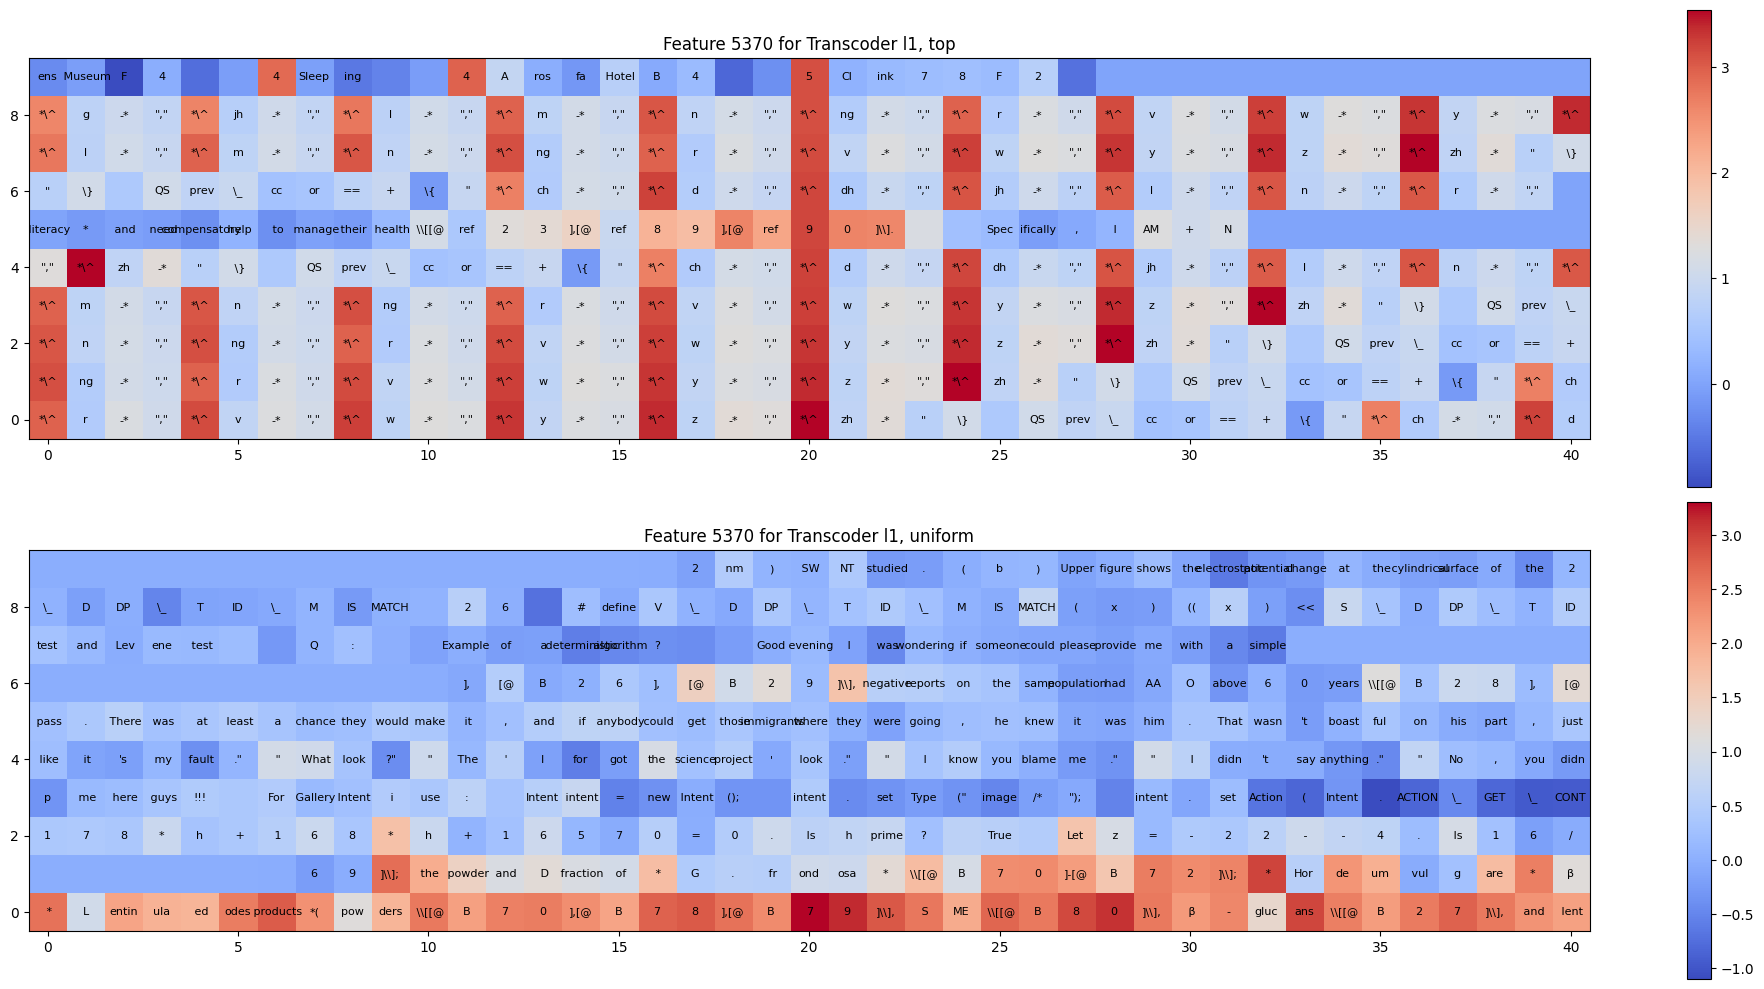

In [ ]:
set_and_visualize(my_sample[0], l=1)

100%|██████████| 10/10 [00:00<00:00, 25.73it/s]


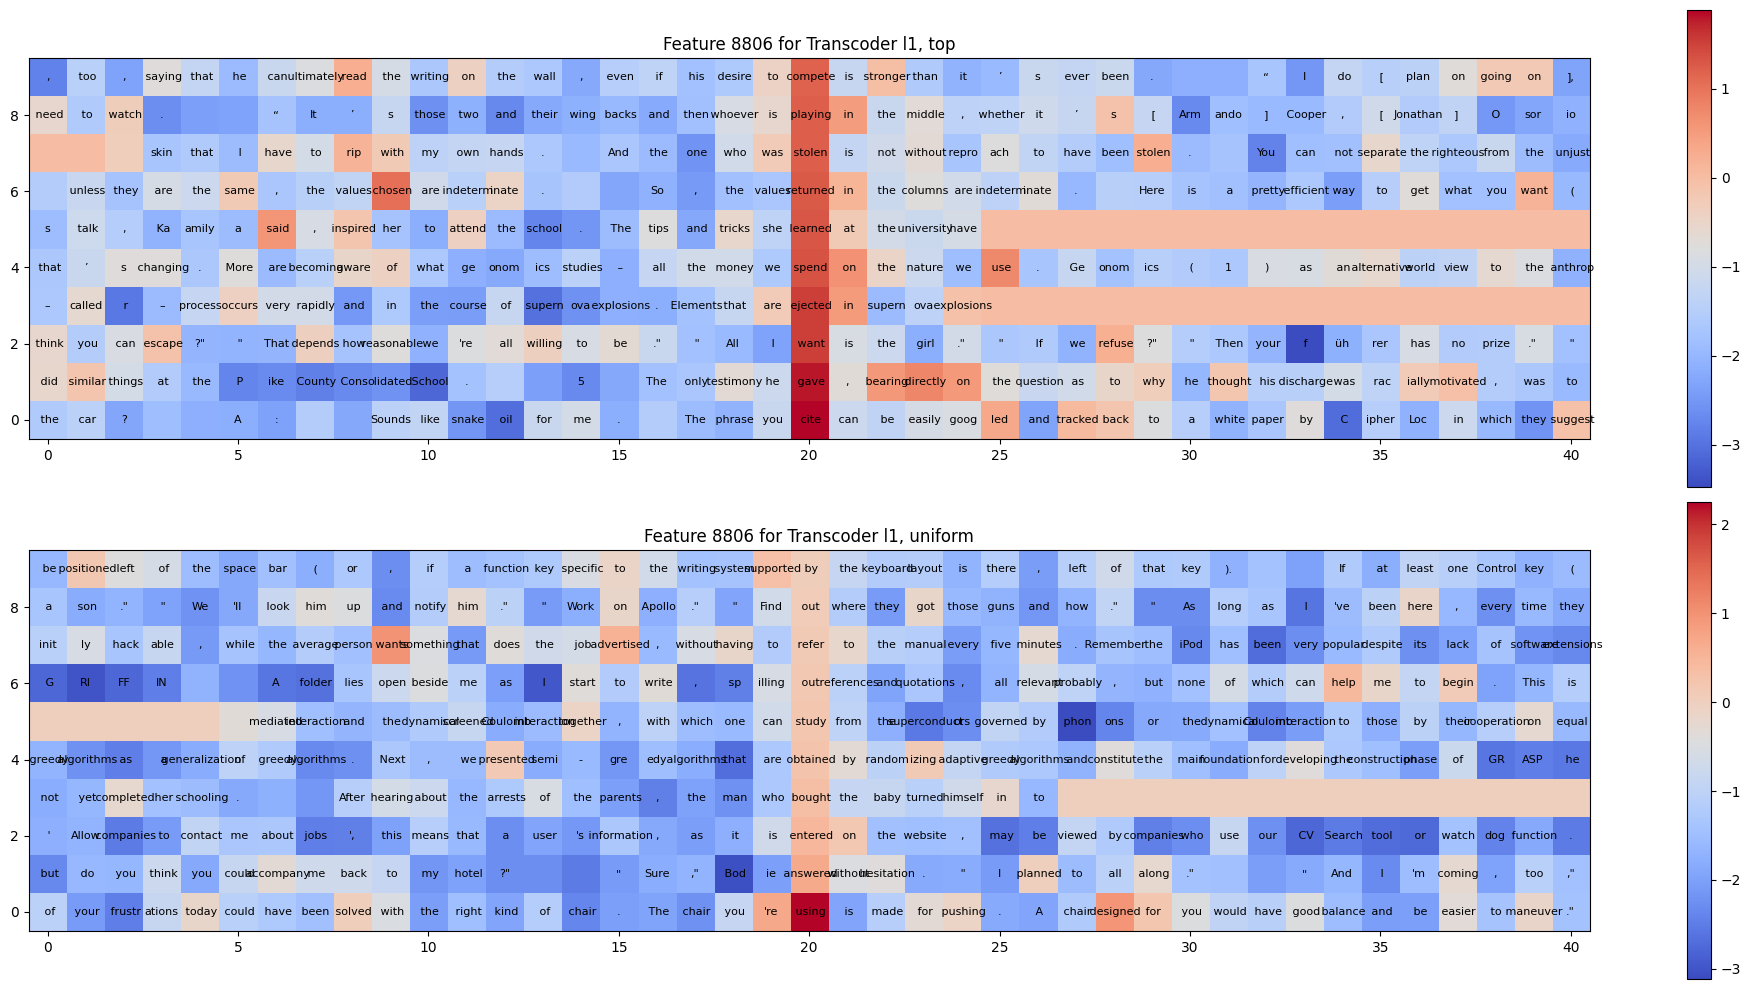

In [ ]:
set_and_visualize(my_sample[1], l=1)

100%|██████████| 10/10 [00:00<00:00, 26.61it/s]
/tmp/ipykernel_668757/1707984514.py:28: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/home/phil/miniconda3/envs/mats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


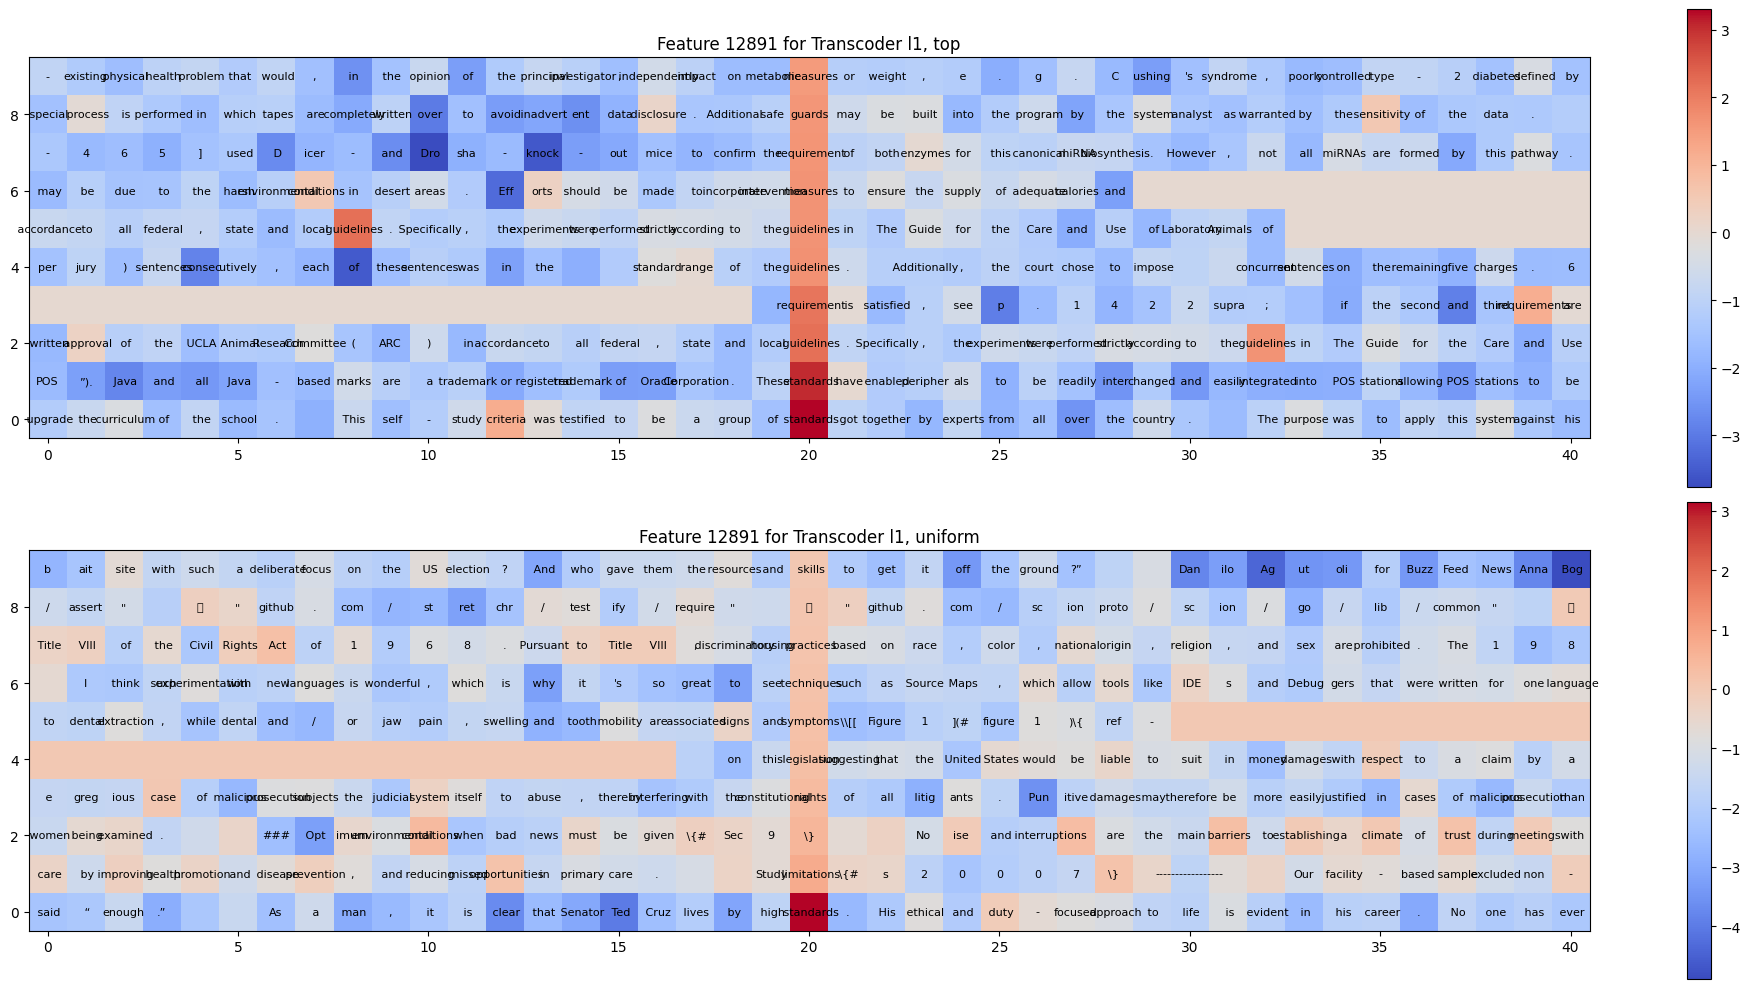

In [ ]:
set_and_visualize(my_sample[2], l=1)

100%|██████████| 10/10 [00:00<00:00, 26.54it/s]


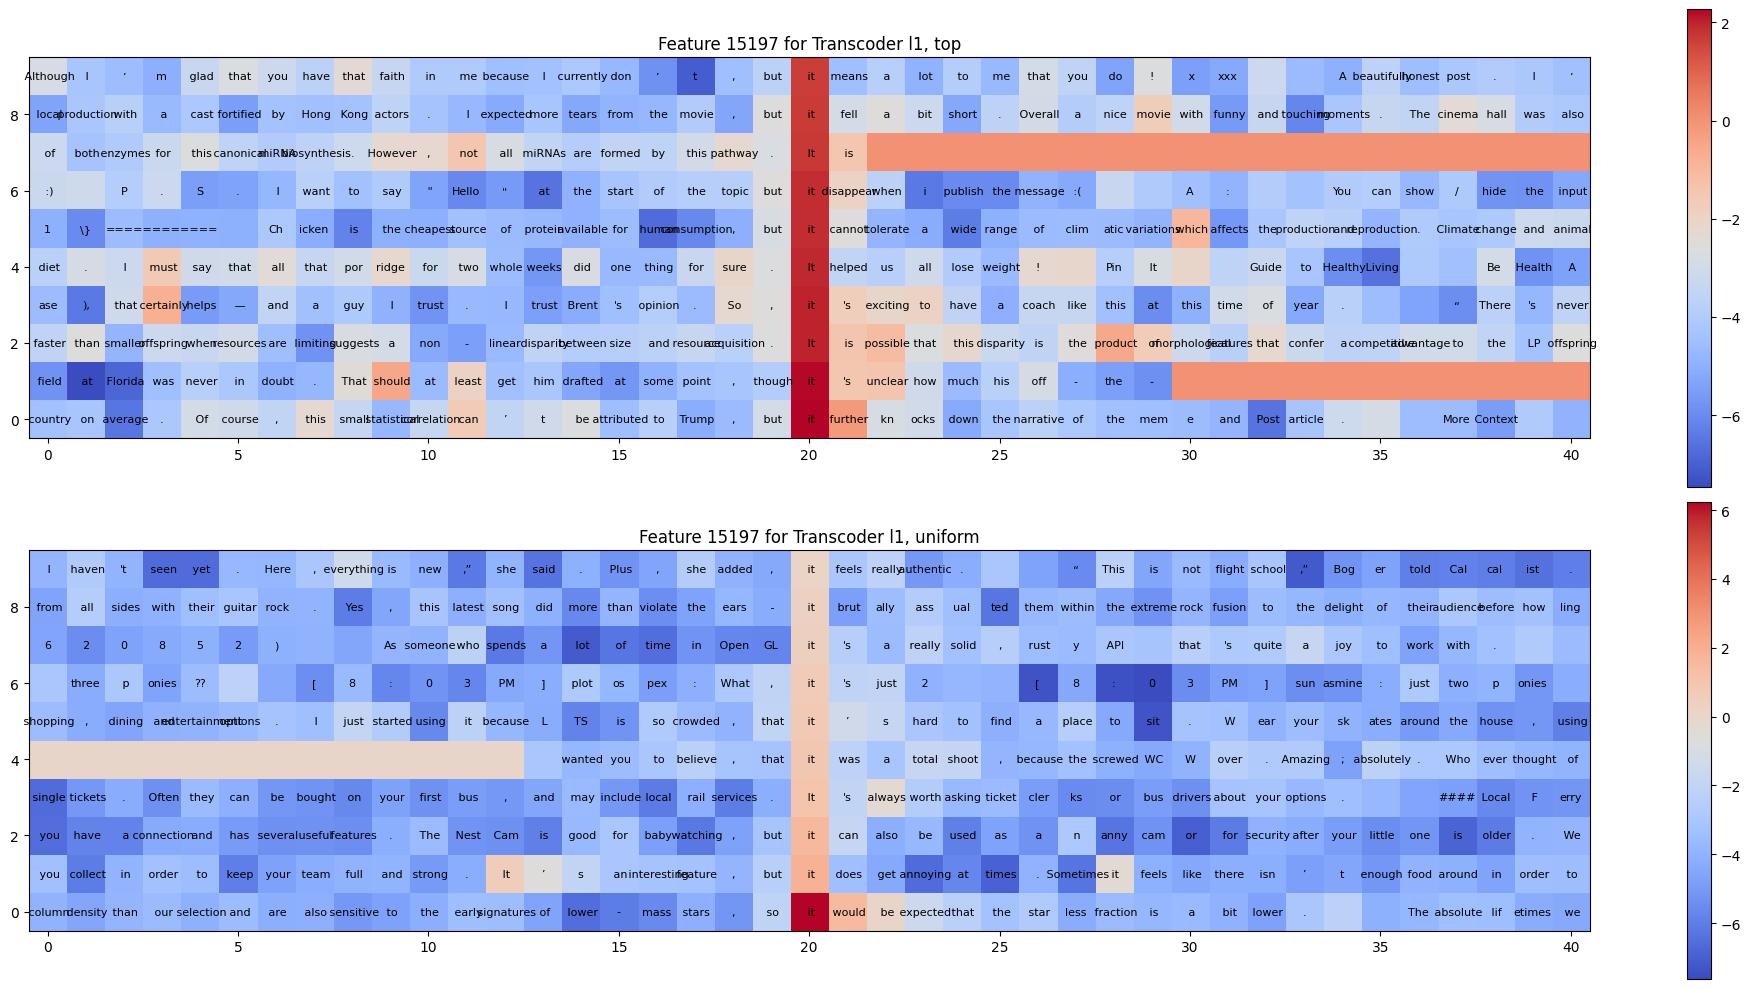

In [ ]:
set_and_visualize(my_sample[3], l=1)

100%|██████████| 10/10 [00:00<00:00, 29.32it/s]


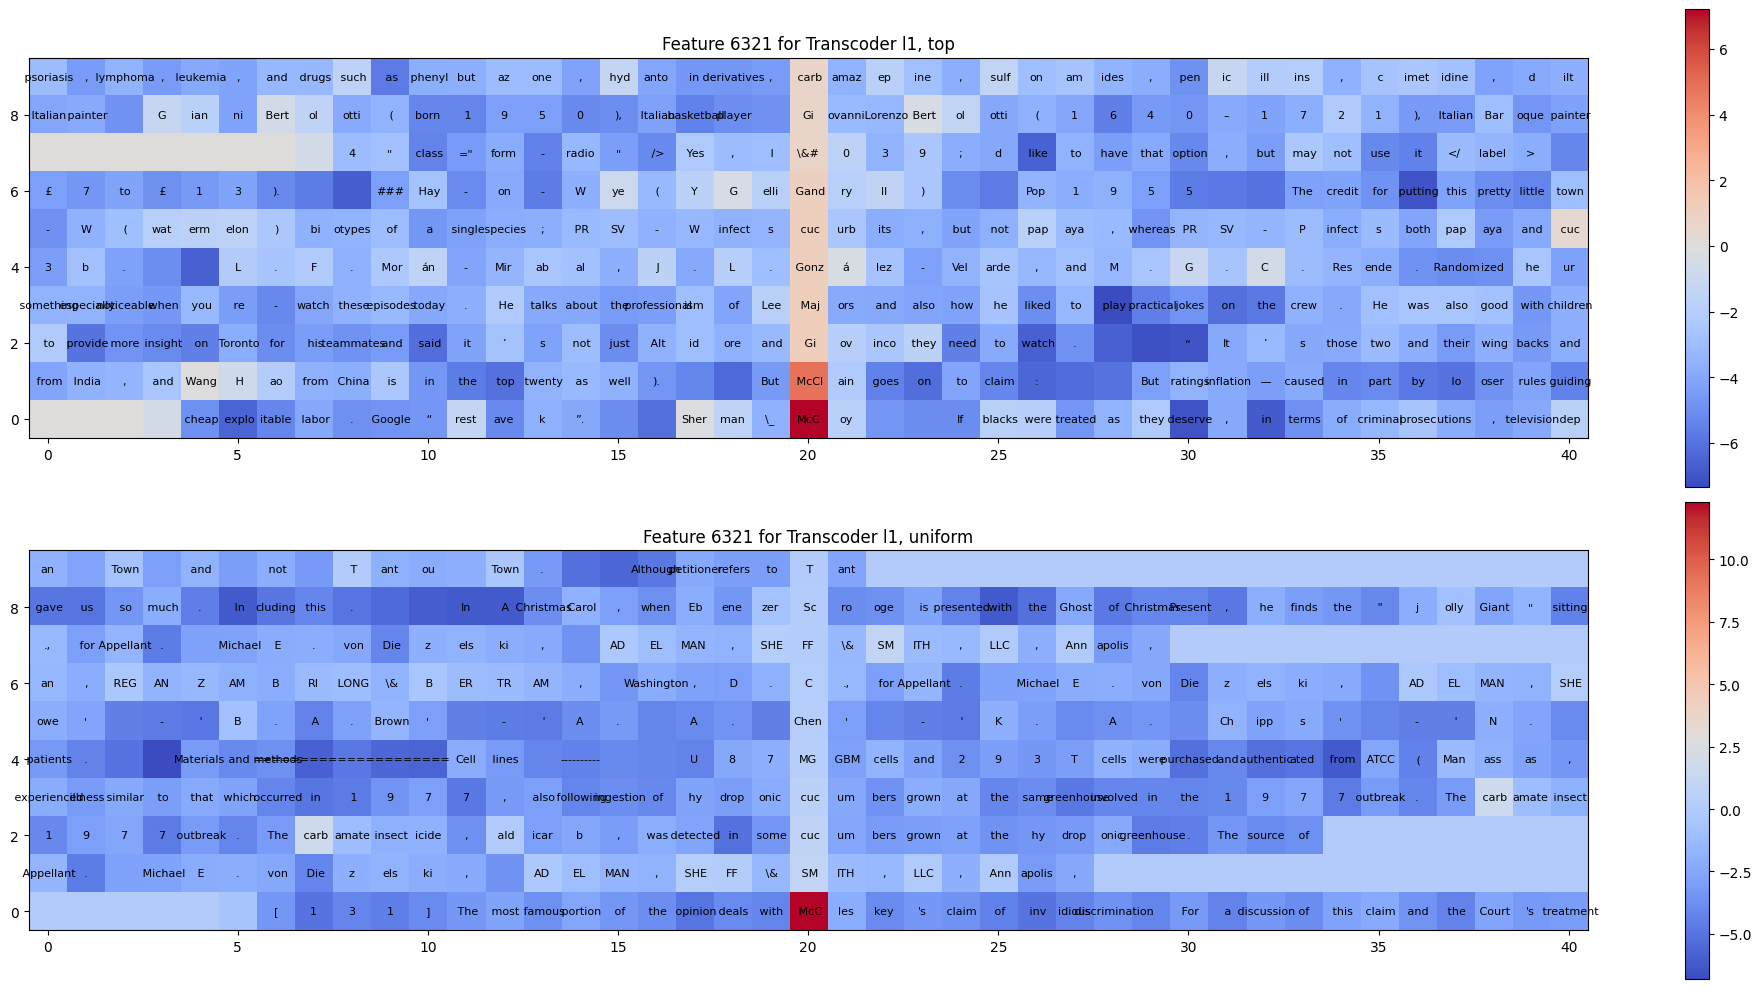

In [ ]:
set_and_visualize(my_sample[4], l=1)